### Install required Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

2024-04-29 23:52:17.494070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 23:52:17.494204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 23:52:17.638012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Display training and testing data

<Axes: >

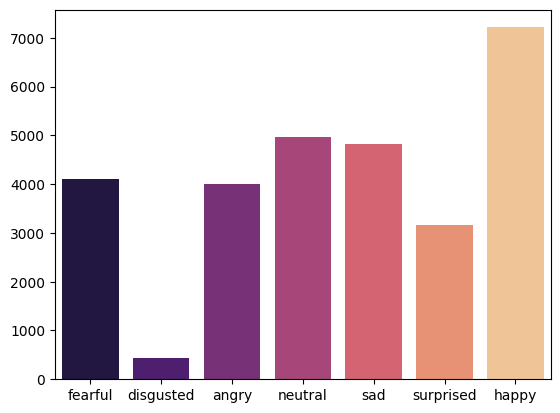

In [ ]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

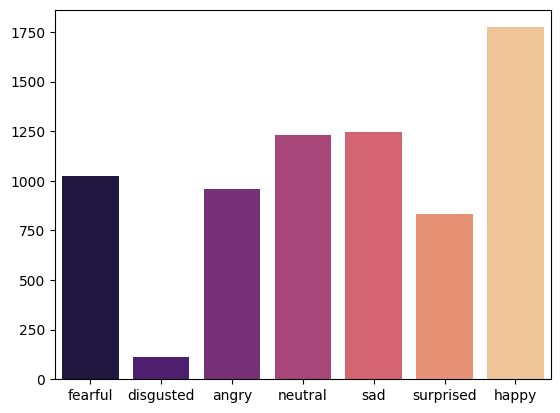

In [ ]:
test_dir = '/kaggle/input/emotion-detection-fer/test'

test_counts = []

for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=test_counts, palette='magma')

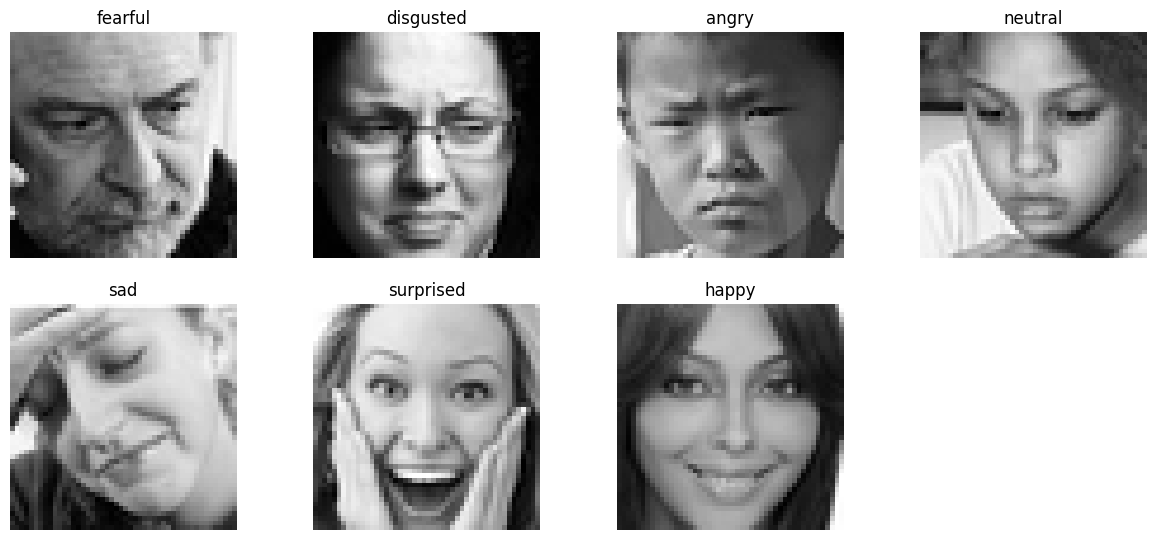

In [ ]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

### Data Pre-processing and Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

### Implementation of Model

In [ ]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=25,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict
)

Epoch 1/25


I0000 00:00:1714434852.804800     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714434852.911131     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.1935 - loss: 1.9225

W0000 00:00:1714434994.911371     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 807ms/step - accuracy: 0.1937 - loss: 1.9225 - val_accuracy: 0.2884 - val_loss: 1.8264
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 525ms/step - accuracy: 0.2681 - loss: 1.8736 - val_accuracy: 0.3519 - val_loss: 1.7358
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 467ms/step - accuracy: 0.3321 - loss: 1.7264 - val_accuracy: 0.4062 - val_loss: 1.5319
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 448ms/step - accuracy: 0.3442 - loss: 1.6659 - val_accuracy: 0.4541 - val_loss: 1.4586
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.3766 - loss: 1.5689 - val_accuracy: 0.4663 - val_loss: 1.4176
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 436ms/step - accuracy: 0.4062 - loss: 1.5524 - val_accuracy: 0.4781 - val_loss: 1.3916
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 446ms/step - accuracy: 0.4190 - loss: 1.5320 - val_accuracy: 0.4884 - val_loss: 1.3360
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 444ms/step - accuracy: 0.4277 - loss: 1.5065 - v

### Model Performance Analysis

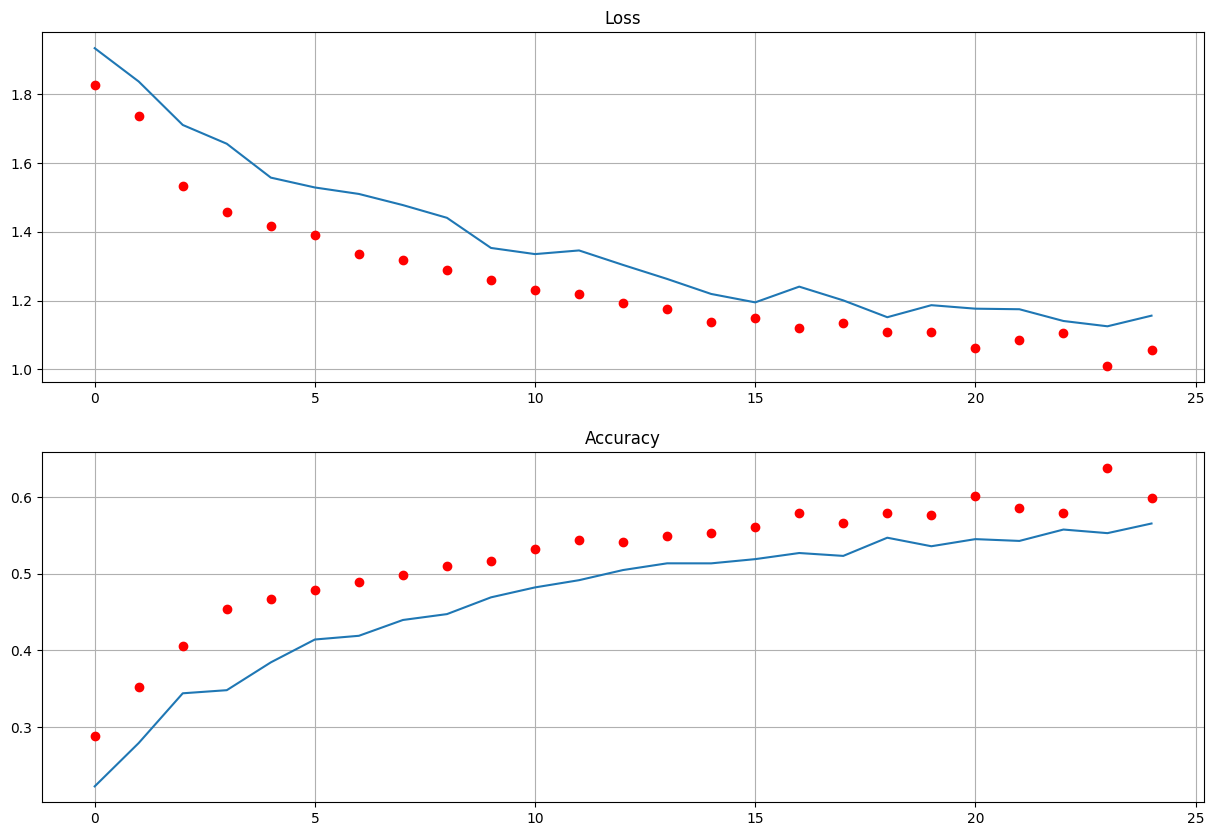

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

In [ ]:
# redefining the test generator so it doesnt shuffle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
  5/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step

W0000 00:00:1714436871.179694     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step


In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.50      0.47      0.49       958
           1       0.37      0.56      0.45       111
           2       0.44      0.27      0.33      1024
           3       0.85      0.83      0.84      1774
           4       0.52      0.67      0.58      1233
           5       0.45      0.46      0.46      1247
           6       0.72      0.76      0.74       831

    accuracy                           0.60      7178
   macro avg       0.55      0.58      0.56      7178
weighted avg       0.60      0.60      0.59      7178



Text(0.5, 1.0, 'Confusion Matrix')

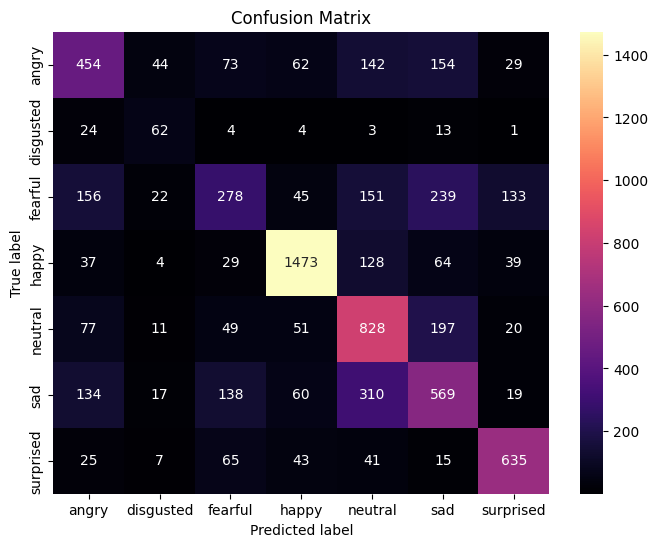

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

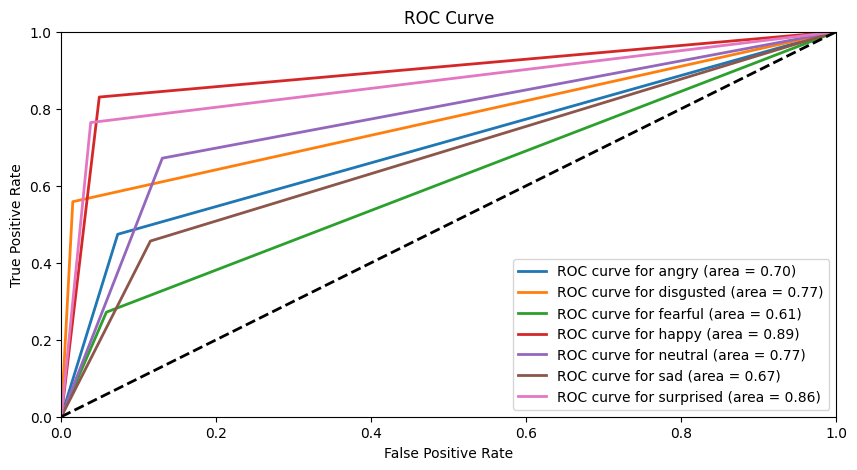

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
### Model Evaluation

In [ ]:
ts_length = len(test_generator)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.5547 - loss: 1.1468
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4844 - loss: 1.2444
Train Loss:  1.138060212135315
Train Accuracy:  0.5625
--------------------
Test Loss:  1.2854437828063965
Test Accuracy:  0.5


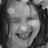

In [ ]:
import IPython
from IPython.display import display
IPython.display.Image(filename='/kaggle/input/emotion-detection-fer/test/happy/im10.png')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

class_labels = ['angry','disgusted','fearful','happy','neutral','sad','surprised']

# Load the image
img_path = '/kaggle/input/emotion-detection-fer/test/happy/im10.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_classes = []
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    predicted_classes.append(predicted_class)

print("Predicted class:", predicted_classes[0], "----  Actual Class: happy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: happy ----  Actual Class: happy


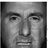

In [ ]:
IPython.display.Image(filename='/kaggle/input/emotion-detection-fer/test/disgusted/im10.png')

In [ ]:
img_path = '/kaggle/input/emotion-detection-fer/test/disgusted/im10.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_classes = []
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    predicted_classes.append(predicted_class)

print("Predicted classes:", predicted_classes[0], "----  Actual Class: disgusted")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted classes: disgusted ----  Actual Class: disgusted


In [ ]:
model.save('model.h5', overwrite=True)